In [15]:

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../procedure_files')

#from tyssue.generation import generate_ring
from tyssue import PlanarGeometry
from tyssue.dynamics import effectors, factory
import imageProcessing as iP
import computingFunctions as cpF
import tyssueMissing
from tyssue.solvers.sheet_vertex_solver import Solver as solver
import time
from scipy import optimize as opt

## Mesh and model initilisation



In [16]:
path = '../images/seek6.png'
imgData = iP.dataImg(path)

#defining de organoid using the data we saved above
Nf = len(imgData.clockwiseCenters)
R_in = imgData.rIn/imgData.shape[1]
R_out = imgData.rOut/imgData.shape[1]
inners = imgData.inside
outers = imgData.outside
centers = imgData.clockwiseCenters

#compute the vertices of the mesh
inner_vs, outer_vs = cpF.get_bissecting_vertices(centers, inners, outers)

#initialising the mesh
organo = tyssueMissing.generate_ring(Nf, R_in, R_out)

# adjustement
organo.vert_df.loc[organo.apical_verts, organo.coords] = inner_vs[::-1]
organo.vert_df.loc[organo.basal_verts, organo.coords] = outer_vs[::-1]

PlanarGeometry.update_all(organo)

# Construction of the model
model = factory.model_factory(
    [effectors.FaceAreaElasticity,
     effectors.LineTension],
    effectors.FaceAreaElasticity)

# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area': organo.face_df.area.mean(), #and there was an error here
        'area_elasticity': 1,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 1e-3,
        'is_active': 1
        },
    'vert':{
        'is_active': 1
        },
    }

organo.update_specs(specs, reset=True)

Reseting datasets values with new specs


## Defining the objective and gradient functions

The variable P contains the line tension and prefered area parameters. When computing the gradient, we save Nf calls to the distance function by computing the partial derivative for only one of each pair of lateral edge. 

In [17]:
def distance(P):   
    L, A = P[:4*Nf], P[4*Nf:]
    tmpOrgano = organo.copy()
    tmpOrgano.edge_df.line_tension = L
    tmpOrgano.face_df.prefered_area = A
    #start = time.clock()
    solver.find_energy_min(tmpOrgano,
                             PlanarGeometry,
                            model,
                            minimize = minimize_opt)
    X = np.column_stack([tmpOrgano.vert_df.x, tmpOrgano.vert_df.y])
    #elapsed = time.clock()-start
    #print('distance computation :',elapsed)
    D = np.sum(np.linalg.norm((X-Y), axis = 1))
    return D

#scipy approx_fprime is slower because it compute the partial derivatice twice for lateral edges 
def grad(P,D):
    h = np.array([10**(-6)]*len(P))
    hP = np.tile(P,(len(P),1)) + np.eye(len(P))*10**(-6)
    start = time.clock()
    Ldf = np.array([distance(i) for i in hP[:3*Nf]]) - np.full(3*Nf,D)
    Ldf = np.concatenate([Ldf,np.roll(Ldf[2*Nf:len(Ldf)],-1)])
    Adf = np.array([distance(i) for i in hP[4*Nf:]]) - np.full(Nf,D)
    df = np.concatenate((Ldf, Adf))
    elapsed = time.clock()-start
    #print('gradient computation : ', round(elapsed,4))
    res = np.divide(df,h)
    return res

Y = np.column_stack([organo.vert_df.x, organo.vert_df.y])

minimize_opt = {'options':{'gtol':0.001,
                           'ftol':0.01}}

## Gradient descent algorithm

The initialization of line tension parameters (L) is designed to ensure that lateral edges have the same line tension in both directions (doubled lateral edges).


In [18]:
start = time.clock()
nonLateral = np.random.rand(int(len(organo.edge_df.line_tension)/2))*0.001
lateral = np.random.rand(int(len(organo.edge_df.line_tension)/4))*0.001
lateral = np.concatenate([lateral,np.roll(lateral,-1)])
L = np.concatenate([nonLateral, lateral])
#L contains line tensions. We need to ad equilibrium areas.
A = np.full(Nf, organo.face_df.area.mean())+np.random.rand(Nf)*0.01
P = np.concatenate((L,A))
D = distance(P)

previousStepSize = 10**6
cpt = 0
incumbent = 10**6

while previousStepSize > 10**(-5) and incumbent > 0:
    cpt += 1   
    P = np.maximum(P - 0.01 / cpt * grad(P,D),np.zeros(len(P)))    
    D = distance(P)
    previousStepSize = abs(D - incumbent)
    #print(f'Itération : {cpt-1} \n Distance : {round(D,5)}')
    #print('________________________________________')
    incumbent = D
optP = P
elapsed = time.clock()-start

# Line tension plot

On the plot above, thicker red edges exhibit high line tensions while thinner green edges exhibit low line tensions.
Results seems to be heavily dependent to the starting point. There are many sets of parameters such that the distance to the observed organoid is equal to 0.



Solving time : 91.88897611042296
Computed energy : 0.007901916326950304
Distance to observed organoid : 0.0


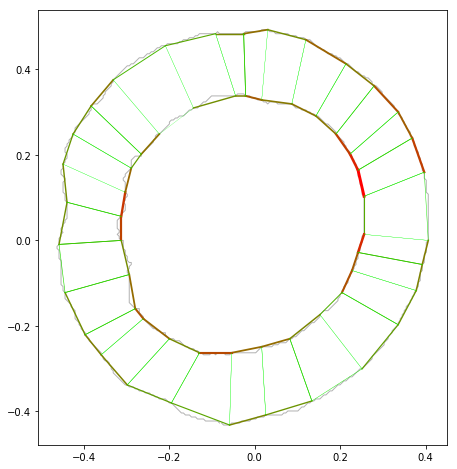

In [23]:
#setting optimal specs
organo.edge_df.line_tension = optP[:4*Nf]
organo.face_df.prefered_area = optP[4*Nf:]
solver.find_energy_min(organo,
                            PlanarGeometry,
                            model,
                            minimize = minimize_opt)
# Plot of the mesh
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.plot(*inners.T, lw=1, alpha=0.6, c='gray')
ax.plot(*outers.T, lw=1, alpha=0.6, c='gray')
fig, ax = tyssueMissing.quick_edge_drawMod(organo, ax=ax)

ax.set(aspect='equal');
print(f'Solving time : {elapsed}\nComputed energy : {model.compute_energy(organo)}\nDistance to observed organoid : {D}')


# Area vs prefered area plot


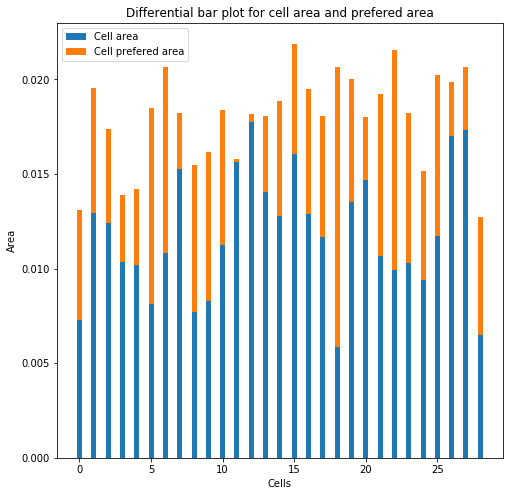

In [24]:
minArea = np.minimum(organo.face_df.area,organo.face_df.prefered_area)
difArea = np.abs(organo.face_df.area-organo.face_df.prefered_area) 

fig, ax = plt.subplots()

p1 = plt.bar(range(Nf), minArea, 0.35)
p2 = plt.bar(range(Nf), difArea, 0.35,
             bottom=minArea)
fig.set_size_inches(8, 8)
plt.xlabel('Cells')
plt.ylabel('Area')
plt.title('Differential bar plot for cell area and prefered area')
plt.legend((p1[0], p2[0]), ('Cell area', 'Cell prefered area'))